In [6]:

import pyautogui

In [8]:
width, height = pyautogui.size()
print(width, height)

2560 1440


In [9]:
currentMouseX, currentMouseY = pyautogui.position()

print(currentMouseX, currentMouseY)

395 523


In [11]:
pyautogui.moveTo(100, 150)

pyautogui.click()
pyautogui.click(100, 200) 
# pyautogui.click('button.png')

In [1]:

from torchsummary import summary
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid       # for data checking
import torchvision.transforms as transforms
import torch.nn.functional as F  # for functions for calculating loss
from PIL import Image           # for checking images
from torch.utils.data import DataLoader  # for dataloaders
import torch.nn as nn           # for creating  neural networks
import matplotlib.pyplot as plt
import torch                    # Pytorch module
import pandas as pd             # for working with dataframes
import numpy as np              # for numerical computationss
import os                       # for working with files
PATH = './plant-disease-model.pth'
# for plotting informations on graph and images using tensors
# for transforming images into tensors
# for working with classes and images
# for getting the summary of our model

%matplotlib inline


# base class for the model
# for calculating the accuracy
# Residual Block code implementation


class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3,
                               kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3,
                               kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        # ReLU can be applied before or after adding the input
        return self.relu2(out) + x

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        # Combine accuracies
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))


def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


# resnet architecture
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()

        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True)  # out_dim : 128 x 64 x 64
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))

        self.conv3 = ConvBlock(128, 256, pool=True)  # out_dim : 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True)  # out_dim : 512 x 4 x 44
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Linear(512, num_diseases))

    def forward(self, xb):  # xb is the loaded batch
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

# model = ResNet9(3, 38)
# model.load_state_dict(state_dict = torch.load(
#     PATH), map_location = torch.device(('cpu')))
# torch.save(model.state_dict(), PATH)


PATH2 = './plant-disease-model-complete.pth'
# torch.save(model, PATH2)
# model.eval()
model = torch.load(PATH2, map_location=torch.device('cpu'))
model.eval()


ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [13]:
test_dir = "New Plant Diseases Dataset(Augmented)/test"
test = ImageFolder(test_dir, transform=transforms.ToTensor())
# since images in test folder are in alphabetical order
test_images = sorted(os.listdir(test_dir + '/test'))
print(test_images)
print(type(test[0][0]))


['AppleCedarRust1.JPG', 'AppleCedarRust2.JPG', 'AppleCedarRust3.JPG', 'AppleCedarRust4.JPG', 'AppleScab1.JPG', 'AppleScab2.JPG', 'AppleScab3.JPG', 'CornCommonRust1.JPG', 'CornCommonRust2.JPG', 'CornCommonRust3.JPG', 'PotatoEarlyBlight1.JPG', 'PotatoEarlyBlight2.JPG', 'PotatoEarlyBlight3.JPG', 'PotatoEarlyBlight4.JPG', 'PotatoEarlyBlight5.JPG', 'PotatoHealthy1.JPG', 'PotatoHealthy2.JPG', 'TomatoEarlyBlight1.JPG', 'TomatoEarlyBlight2.JPG', 'TomatoEarlyBlight3.JPG', 'TomatoEarlyBlight4.JPG', 'TomatoEarlyBlight5.JPG', 'TomatoEarlyBlight6.JPG', 'TomatoHealthy1.JPG', 'TomatoHealthy2.JPG', 'TomatoHealthy3.JPG', 'TomatoHealthy4.JPG', 'TomatoYellowCurlVirus1.JPG', 'TomatoYellowCurlVirus2.JPG', 'TomatoYellowCurlVirus3.JPG', 'TomatoYellowCurlVirus4.JPG', 'TomatoYellowCurlVirus5.JPG', 'TomatoYellowCurlVirus6.JPG']
<class 'torch.Tensor'>


In [6]:

train_dir = "New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
train = ImageFolder(train_dir, transform=transforms.ToTensor())


def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")


device = get_default_device()

def to_device(data: torch.Tensor, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    # print(type(data))
    return data
    # return data.to(device, non_blocking=True)

def predict_image(img, model):
    """Converts image to array and return the predicted class
        with highest probability"""
    # Convert to a batch of 1
    if torch.cuda.is_available():
        xb = to_device(img.unsqueeze(0), device)
    else:
        xb = img.unsqueeze(0)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds = torch.max(yb, dim=1)
    # Retrieve the class label

    return train.classes[preds[0].item()]




Label: AppleCedarRust1.JPG , Predicted: Apple___Cedar_apple_rust
<class 'torch.Tensor'> torch.Size([3, 256, 256]) torch.Size([3, 256, 256])


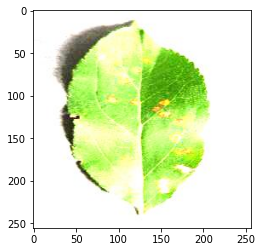

In [17]:
# predicting first image
PATH2 = './plant-disease-model-complete.pth'
# torch.save(model, PATH2)
# model.eval()
model = torch.load(PATH2, map_location=torch.device('cpu'))
model.eval()
img, label = test[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_images[0], ', Predicted:', predict_image(img, model))
print(type(img), img.shape, img.size())


In [10]:
# getting all predictions (actual label vs predicted)
with open('predictions.txt', 'w') as f:
	for i , (img, label) in enumerate(test):
		pred = predict_image(img, model)
		f.write(f'Label : {test_images[i]}, Predicted: {pred}\n')
